# AlexNet-Keras

In [1]:
import keras
import numpy as np
from PIL import Image
import keras.layers as LayerS
from keras.models import Sequential

from LoadDataset import  *

Using TensorFlow backend.


在使用Keras搭建AlexNet之前,需要注意的是在Keras中并未定义LRN函数,这里我也就不定了,如果想定义的话可以自定义定义.可以参考一下代码:

[LRN](https://github.com/ckoren1975/Machine-learning/blob/master/googlenet_custom_layers.py)

另外我们需要在```fit_generator```中传递```steps_per_epoch```以及```validation_steps```,用于定义一个epoch的大小,同样我们也会遇到batch size大于总样本数的情况,那么如果**如果给予的batch size大于样本总数,那么我们需要将整除结果设置为1.**

### 1. Build AlexNet Model

下面我们来构建AlexNet模型,整体的框架如下显示:

![](../../../../picture/182.png)

函数```AlexNet```接受一下参数:

file_dir: 训练数据的路径.

Load_samples: 加载的总样本数,如果为```None```表示加载所有样本.

test_rate: 测试样本率.

drop_rate: dropout 层的参数,以```drop_rate```的概率将神经元归0.

lr: 学习率,使用与```RMSProp```激活函数.

batch_size: 每次在迭代器中残生的批次大小.

save_path: 保存训练完毕后的模型路径.

In [2]:
def AlexNet(file_dir,Load_samples,test_rate,drop_rate,lr,batch_size,save_path=None):
    """
    Argus:
    ------
        file_dir (string): data set file path. like "../train"
        Load_samples (Int): Load data number. if given None, load all samples.
        test_rate (float): split test data rate.
        drop_rate (float): dropout layers parameter, dropout_rate = 1 - keep prob.
        lr (float): learning rate with RMSProp.
        batch_size (Int): batch size.
        save_path (string): save model path, if not equal None.

    Return:
    ------
        model (class): Sequential model.
    """

    # Split training set and testing set.
    split_data = SplitData(file_dir,Load_samples=Load_samples,Shuffle=True,test_rate=test_rate)
    train_files, test_files, train_samples, test_samples = split_data()

    print('Train Samples: {}'.format(train_samples))
    print('Test Samples: {}'.format(test_samples))

    m_train = len(train_files)
    N_train = int(np.maximum(m_train // batch_size,1))


    m_test = len(test_files)
    N_test = int(np.maximum(m_test // batch_size,1))

    # Create Model.
    model = Sequential()
    # CONV1
    model.add(
        LayerS.Conv2D(filters=96,kernel_size=(11,11),
                      strides=(4,4),padding='valid',input_shape=(227,227,3)))
    model.add(
        LayerS.Activation('relu'))
    model.add(
        LayerS.MaxPool2D(pool_size=(3,3),strides=(2,2),padding='valid'))
    # Normal

    # CONV2
    model.add(
        LayerS.Conv2D(filters=256,kernel_size=(5,5),
                      strides=(1,1),padding='same'))
    model.add(
        LayerS.Activation('relu'))
    model.add(
        LayerS.MaxPool2D(pool_size=(3,3),strides=(2,2),padding='valid'))
    # Normal2

    # CONV3
    model.add(
        LayerS.Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding='same'))
    model.add(
        LayerS.Activation('relu'))

    # CONV4
    model.add(
        LayerS.Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding='same'))
    model.add(
        LayerS.Activation('relu'))

    # CONV5
    model.add(
        LayerS.Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same'))
    model.add(
        LayerS.Activation('relu'))
    model.add(
        LayerS.MaxPool2D(pool_size=(3,3),strides=(2,2),padding='valid'))

    # FC6
    model.add(
        LayerS.Flatten())
    model.add(
        LayerS.Dense(units=4096))
    model.add(
        LayerS.Activation('relu'))
    model.add(
        LayerS.Dropout(rate=drop_rate)
    )

    # FC7
    model.add(
        LayerS.Dense(units=4096))
    model.add(
        LayerS.Activation('relu'))
    model.add(
        LayerS.Dropout(rate=drop_rate))

    # FC8
    model.add(
        LayerS.Dense(units=1000))
    model.add(
        LayerS.Activation('relu'))
    model.add(
        LayerS.Dropout(rate=drop_rate))

    # output
    model.add(
        LayerS.Dense(units=1))

    model.add(
        LayerS.Activation('sigmoid'))

    # create loss.
    loss = keras.losses.binary_crossentropy
    # create optimizer.
    optimizer = keras.optimizers.RMSprop(lr=lr)

    # compile model.
    model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])
    # fit model at generator.
    model.fit_generator(generate_train(train_files,batch_size),
                        steps_per_epoch=N_train,epochs=13,validation_data=generate_test(test_files,batch_size),
                        validation_steps=N_test)

    # save model.
    if save_path:
        print('Saving Model In {}'.format(save_path))
        model.save(save_path)
    return model

该函数首先按照AleNet定义模型,使用keras中的```Sequential```定义.需要注意的是,由于AlexNet中最后的输出是1000类,而我们这里只是二分类,所以我们会加上一层```FC8```以便于输出1个神经元.

模型中使用```binary_crossentropy```损失函数以及```RMSprop```激活函数.我们总共迭代13次.由于我们的训练样本也是比较大的,所以我们也使用generate```generate_test```函数.

最后将模型Push到Google Cloud上进行训练,训练时长大约带一个小时,并保存在名为**Alexnet_Keras_model.h5**的文件中.

In [ ]:
file_dir = '/Users/huwang/Joker/Data_Set/catVSdot/train'
save_path = 'Alexnet_Keras_model.h5'
AlexNet(file_dir, Load_samples=None, test_rate=0.3, drop_rate=0.3, lr=1e-4, batch_size=100,save_path=save_path)

![](../../../../picture/209.png)

可以看出模型还是有些许过拟合.可以更改```dropout_rate```进行尝试,另外由于我们这里没有加载```LRN```,实际上个人建议使用```BatchNoraml```更加好.这里就不在尝试了.

### 2. Predict

下面我们使用LoadDataset中的```Crop```生成测试样本进行测试.

In [3]:
def Predict(file_path,model_path):
    """
    Argus:
    ------
        file_path (string): predict picture path.
        model_path (string): Sequential model path.

    Return:
    ------
        None.

    """
    crop = Crop(file_path)
    Img = crop()
    model = keras.models.load_model(model_path)
    predict = model.predict(Img)
    predict = np.round(predict)
    dog_rate = np.sum(predict) /  predict.size
    cat_rate = 1 - dog_rate

    print('The Picture is dog :{} %'.format(dog_rate * 100))
    print('The Picture is cat :{} %'.format(cat_rate * 100))

#### 2.1 Cat

首先我们测试一下cat的图片.

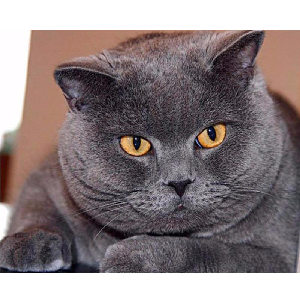

In [4]:
file_path ='cat.jpeg'
img = Image.open(file_path)
img =img.resize((300,300))
img

In [5]:
model_path = 'Alexnet_Keras_model.h5'
Predict(file_path,model_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
The Picture is dog :0.0 %
The Picture is cat :100.0 %


#### 2.2 Dog

现在我们来测试一下dog的图片.

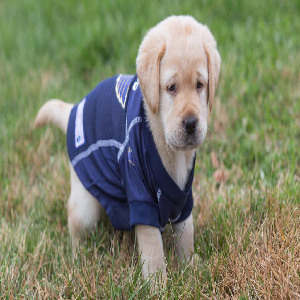

In [6]:
file_path ='dog.jpg'
img = Image.open(file_path)
img =img.resize((300,300))
img

In [7]:
model_path = 'Alexnet_Keras_model.h5'
Predict(file_path,model_path)

The Picture is dog :100.0 %
The Picture is cat :0.0 %
